# indicators - NASA indicate sealevel
<a href="https://app.naas.ai/user-redirect/naas/downloader?url=https://raw.githubusercontent.com/jupyter-naas/awesome-notebooks/master/WHI/indicators/NASA_indicate_sealevel.ipynb" target="_parent">
<img src="https://img.shields.io/badge/-Open%20in%20Naas-success?labelColor=000000&logo="/>
</a>

# Inputs

In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import date, datetime, timedelta
import math
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
)
import matplotlib.pyplot as plt
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import (
    MeanAbsolutePercentageError,
    mean_absolute_percentage_error,
)
from scipy.interpolate import interp1d
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import os
import sys
import tempfile
import dateutil.parser
import matplotlib.dates as mdates
import naas

## Dataset
Source: Nasa (https://climate.nasa.gov/vital-signs/sea-level/)
URL: https://podaac-tools.jpl.nasa.gov/drive/files/allData/merged_alt/L2/TP_J1_OSTM/global_mean_sea_level/GMSL_TPJAOS_5.0_199209_202102.txt

In [5]:
'''
Column descriptions
    1 altimeter type 0=dual-frequency  999=single frequency (ie Poseidon-1) 
    2 merged file cycle # 
    3 year+fraction of year (mid-cycle) 
    4 number of observations 
    5 number of weighted observations 
    6 GMSL (Global Isostatic Adjustment (GIA) not applied) variation (mm) with respect to 20-year 
        TOPEX/Jason collinear mean reference 
    7 standard deviation of GMSL (GIA not applied) variation estimate (mm)
    8 smoothed (60-day Gaussian type filter) GMSL (GIA not applied) variation (mm)  
    9 GMSL (Global Isostatic Adjustment (GIA) applied) variation (mm) with respect to 20-year 
        TOPEX/Jason collinear mean reference 
    10 standard deviation of GMSL (GIA applied) variation estimate (mm)
    11 smoothed (60-day Gaussian type filter) GMSL (GIA applied) variation (mm)
    12 smoothed (60-day Gaussian type filter) GMSL (GIA applied) variation (mm); 
      annual and semi-annual signal removed
Learn more @ https://sealevel.colorado.edu/presentation/what-definition-global-mean-sea-level-gmsl-and-its-rate
'''
pass

# Model

In [6]:
indicator = SeaLevelIndicator('nasa-sea-level-data.txt')

In [7]:
'''
This is safer to use - it gives a value more inline with current projections, 
but can be reused with additional data
'''
indicator.value(method='curve_fit')

4.951165245651996

In [9]:
df

,DATE_PROCESSED,INDICATOR,VALUE
0,2021-05-28,Sea Level,4.951165


In [8]:
df = indicator.value_df()
path = '../output/nasa_sealevel_output.csv'
df.to_csv(path)
naas.assets.add(path)

👌 Well done! Your Assets has been sent to production.



/opt/conda/lib/python3.8/site-packages/naas/assets.py:30: UserWarning: [Warning], naas.assets is deprecated,
 use naas.asset instead, it will be remove in 1 june 2021
  warnings.warn(


<IPython.core.display.Javascript object>

Button(button_style='primary', description='Copy URL', style=ButtonStyle())

Output()

PS: to remove the "Assets" feature, just replace .add by .delete


'https://public.naas.ai/c29mdHdhcmUtNDBwZXRlcnR1cm5lci0yRWNvLTJFemE=/asset/e0a73cb6962e76df3263d72eeb925eae0eb2647655fc5a0f8ba5d137c939'

In [39]:
df.to_csv('data_')

In [14]:
indicator.value(method='arima')

9.672612457127427

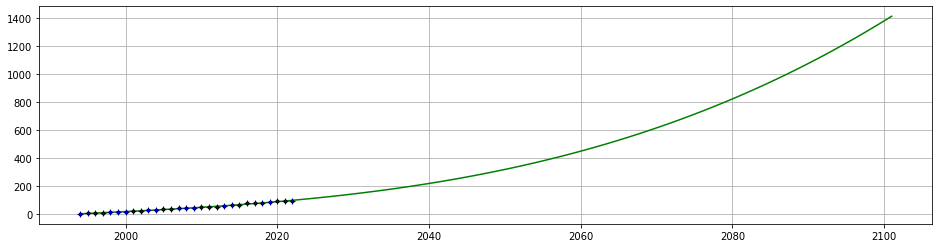

In [15]:
indicator.plot_projection(method='curve_fit')

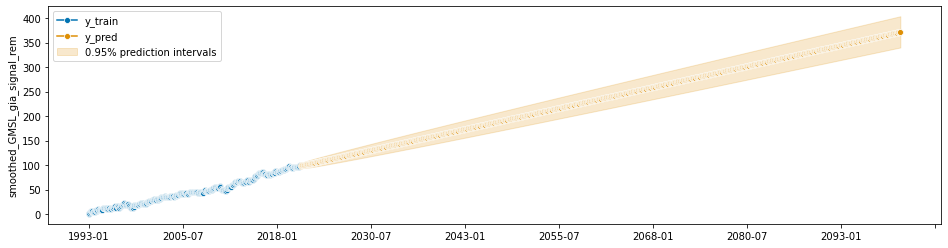

In [26]:
indicator.plot_projection(method='arima')

In [3]:
class SeaLevelIndicator():
    def __init__(self, filepath):
        self.filepath = filepath
        self.df = self.get_df()
        
        
    def value_df(self, method='curve_fit'):
        value = self.value(method)
        data = {'DATE_PROCESSED': [datetime.today().date()],
                'INDICATOR': 'Sea Level',
                 'VALUE': [indicator.value()]}
        return pd.DataFrame.from_dict(data)
        
    def value(self, method='curve_fit'):
        # interpolate value out of ten
        m = (10-0)/(self.best_case(value_only=True)-self.worst_case(value_only=True))
        c = -self.worst_case(value_only=True) * m
        return m * self.current_projection(method=method, value_only=True) + c
    
    def current_projection(self, method='curve_fit', value_only=False):
        value = None
        if method.lower() == 'curve_fit':
            x = mdates.date2num(self.df_per_year['smoothed_GMSL_gia_signal_rem'].index)
            y = (self.df_per_year['smoothed_GMSL_gia_signal_rem'] \
                 + abs(self.df_per_year['smoothed_GMSL_gia_signal_rem'].min())).values
            z4 = np.polyfit(x, y, 3)
            p4 = np.poly1d(z4)
            xx = np.linspace(x.min(), mdates.date2num(datetime(2100, 12, 31)), 100)
            dd = mdates.num2date(xx)
            df = pd.DataFrame(data=p4(xx), index=dd) 
            value = df.iloc[-1].values[0]
        elif method.lower() == 'arima':
            df = self.df_starting_from_zero.copy()
            df = df.resample('M').mean()
            df.index = pd.PeriodIndex(df.index, freq="M")
            y_train, y_test = temporal_train_test_split(df['smoothed_GMSL_gia_signal_rem'],
                                                        test_size=180)
            future_months = (pd.Period('2100-12') - df['smoothed_GMSL_gia_signal_rem'].index[-1]).n
            forecaster = AutoARIMA(sp=12, suppress_warnings=True)
            alpha = 0.05  # 95% prediction intervals
            fh = np.arange(future_months) + 1 # forecast_horizon
            forecaster.fit(df['smoothed_GMSL_gia_signal_rem'])
            y_pred, pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)
            value = y_pred.iloc[-1]
        if value_only:
            return value
        return {'date': 'December 2100',
                 'period': '2100-12',
                 'units': 'Sea Level above 2000 Levels (mm)',
                 'value': value}
            
    def best_case(self, value_only=False):
        # Source: https://tidesandcurrents.noaa.gov/publications/techrpt83_Global_and_Regional_SLR_Scenarios_for_the_US_final.pdf
        recorded_value = 300
        if value_only:
            return recorded_value
        return {'date': 'December 2100', 'period': '2100-12', 
                'units': 'Sea Level above 2000 Levels (mm)', 'value': recorded_value}
    
    def worst_case(self, value_only=False):
        # Source: https://tidesandcurrents.noaa.gov/publications/techrpt83_Global_and_Regional_SLR_Scenarios_for_the_US_final.pdf
        recorded_value = 2500
        if value_only:
            return recorded_value
        return {'date': 'December 2100', 'period': '2100-12', 
                'units': 'Sea Level above 2000 Levels (mm)', 'value': recorded_value}
    
    def plot_projection(self, method='curve_fit'):
        if method.lower() == 'curve_fit':
            x = mdates.date2num(self.df_per_year['smoothed_GMSL_gia_signal_rem'].index)
            y = (self.df_per_year['smoothed_GMSL_gia_signal_rem'] \
                 + abs(self.df_per_year['smoothed_GMSL_gia_signal_rem'].min())).values
            z4 = np.polyfit(x, y, 3)
            p4 = np.poly1d(z4)

            fig, cx = plt.subplots(figsize=(16, 4))

            xx = np.linspace(x.min(), mdates.date2num(datetime(2100, 12, 31)), 100)
            dd = mdates.num2date(xx)

            cx.plot(dd, p4(xx), '-g')
            cx.plot(x, y, '+', color='b', label='blub')
            cx.errorbar(x, y,
                         marker='.',
                         color='k',
                         ecolor='b',
                         markerfacecolor='b',
                         label="series 1",
                         capsize=0,
                         linestyle='')
            cx.grid()
            plt.show()
            
        elif method.lower() == 'arima':
            # Set the frequency of the index, Sktime needs this to work
            df = self.df_starting_from_zero.copy()
            df = df.resample('M').mean()
            df.index = pd.PeriodIndex(df.index, freq="M")
            y_train, y_test = temporal_train_test_split(df['smoothed_GMSL_gia_signal_rem'],
                                                        test_size=180)
            future_months = (pd.Period('2100-12') - df['smoothed_GMSL_gia_signal_rem'].index[-1]).n
            forecaster = AutoARIMA(sp=12, suppress_warnings=True)
            alpha = 0.05  # 95% prediction intervals
            fh = np.arange(future_months) + 1 # forecast_horizon
            forecaster.fit(df['smoothed_GMSL_gia_signal_rem'])
            y_pred, pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)
            fig, ax = plot_series(df['smoothed_GMSL_gia_signal_rem'], 
                                  y_pred, labels=["y_train", "y_pred"])
            ax.fill_between(
                ax.get_lines()[-1].get_xdata(),
                pred_ints["lower"],
                pred_ints["upper"],
                alpha=0.2,
                color=ax.get_lines()[-1].get_c(),
                label=f"{1 - alpha}% prediction intervals",
            )
            ax.legend();
            
            
    def get_df(self):
        cols = ['altimeter_type','merged_file_cycle_#','yearfrac','num_obs','num_w_obs', 'GMSL_variation_mm',
        'std_GMSL','smoothed_GMSL','GMSL_GIA_variation_mm','std_GMSL_GIA','smoothed_gia_GMSL',
        'smoothed_GMSL_gia_signal_rem']
        with open(self.filepath, 'r') as f:
            data = f.read()
        data = [d[1:] for d in data.split('\n') if 'HDR' not in d]
        df = pd.DataFrame([l.split() for l in data], dtype=float, columns=cols)
        # Pre-processing        
        def convert_yearfrac_to_datetime(yearfrac):
            year = int(yearfrac)
            rem = yearfrac - year
            base = datetime(year, 1, 1)
            return base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
        df['datetime'] = df['yearfrac'].apply(lambda year: convert_yearfrac_to_datetime(year))
        df = df[['datetime', 'smoothed_GMSL_gia_signal_rem']].set_index('datetime')
        return df
    
    def current_value(self, value_only=False):
        res = requests.get('https://climate.nasa.gov/vital-signs/sea-level/')
        soup = BeautifulSoup(res.text, 'html.parser')
        measurement = soup.find_all("div", {"class": "latest_measurement"})[0]
        date = measurement.find("span", {"class": "month_year"}).text.strip()
        value = measurement.find("div", {"class": "value"}).text.split('(')[0].strip()
        if value_only:
            return value
        try:
            period = dateutil.parser.parse(date).strftime('%Y-%m')
        except:
            period = None
        return {'date': date, 'period': period, 'current_value': value}
    
    @property
    def df_starting_from_zero(self):
        return self.df + abs(self.df.min()) # Here we add the minimum ensure measurements start at zero
    
    @property
    def df_per_year(self):
        return self.df.resample('Y').mean()
        
        